In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
"""
Purpose: 
- work towards a script that can automate an annotated heatmap for each school's aptitude-interest frequency
- - - Need to create an object that has all of the aptitude and interest fits from YouScience to ensure compatability
<> create an object that contains the POS offerings by school

Discovery:
- Need to clean POS labels: there are typos and inconsistent labels
- Need to clarify matching criteria for how students get placed into a POS
"""

In [7]:
# compiling POS offerings by school
# two objects: (1) offerings by school, (2) overall offerings across RCS
test = pd.read_excel('../YouScienceData/Career Fairs Planning.xlsx', sheet_name=None)
schools = list(test.keys())

In [56]:
RCS_POS_offerings = set()
RCS_POS_per_school = {}
for school in schools:
    # test[school] is a pandas df object
    df = test[school]
    l = []
    # add the POS offerings to a list
    for pos in df.POS.dropna():
        # ignoring the headers for the rest of the spreadsheet
        if ("High School" not in pos) and ("Notes" not in pos):
            l.append(pos)
        else:
            break
    RCS_POS_per_school[school] = l
    RCS_POS_offerings = RCS_POS_offerings.union(set(l))
    

In [57]:
len(RCS_POS_offerings)

52

In [54]:
# 'cul'; 'STEM'; 'Agri'
for pos in list(RCS_POS_offerings):
    if 'STEM' in pos:
        print(pos)

Advanced STEM Applications
STEM: Engineering
STEM Technology
STEM
BioSTEM
STEM Engineering


In [225]:
def YouScienceDemand(YS_data_folder_path):
    # function that takes prepped df and runs co-occurrence matrix and generates heatmaps.
    def MakeHeatmap(df, school=None, level=1):
        # checking if filter to specific school
        if school is not None: 
            df = df[df.organization == school]
        
        fits = list(set(df.aptitude_fit).union(df.interest_fit))
        for fit in fits:
            df.loc[df.aptitude_fit == fit, 'A: ' + fit] = 1
            df.loc[df.interest_fit == fit, 'I: ' + fit] = 1 
        
        df.replace(np.nan,0,inplace=True)

        cols = []
        for col in list(df.columns):
            if ('A:' in col) or ('I:' in col):
                cols.append(col)
        
        # preparing co-occurrence matrix
        base_df = df[df.fit_rank == level]
        base_df = base_df[cols].astype(int)
        cooc = base_df.T.dot(base_df)
        np.fill_diagonal(cooc.values,0)

        # getting quadrant 1 of matrix, since A's won't be paired with A's and same with I's
        for col in list(cooc.columns):
            if 'A:' in col:
                cooc.drop(col, axis=0,inplace=True)
            else:
                cooc.drop(col, axis=1, inplace=True)
        
        # generating title for heatmap
        if school is not None:
            name = school 
        else:
            name = 'All of RCS'
            
        cooc.to_csv('../Heatmaps/' + name + 'cooc.csv')

        name += ', fit_rank = ' + str(level)
        fig, ax = plt.subplots(figsize=(18,7))
        plt.title(label=name)
        sns.heatmap(cooc, annot=cooc.values, ax=ax) 
        plt.savefig('../Heatmaps/'+name+'.png', dpi=400)
          

        return
    # Create a combined RCS df with all the schools rankings
    # The "School" feature details the school the student attends
    schools = []
    RCS_ranked_df = None
    for filename in os.listdir(YS_data_folder_path):
        if '.csv' in filename:
            # extracting school name to key the data by school 
            if RCS_ranked_df is None:
                RCS_ranked_df = pd.read_csv(YS_data_folder_path + filename)
                
            else:
                df = pd.read_csv(YS_data_folder_path + filename)
                
                RCS_ranked_df = pd.concat([RCS_ranked_df,df], ignore_index=True)
    
    schools = list(set(RCS_ranked_df.organization))
    #tidy the features
    cols = list(RCS_ranked_df.columns)
    ftd = ['email','phone','gender','ethnicity','grad_year']
    for feature in ftd:
        cols.remove(feature)

    # export compiled df
    RCS_ranked_df.to_csv('../Heatmaps/RCS_compiled.csv')
    
    MakeHeatmap(RCS_ranked_df)


    return RCS_ranked_df
    

27927

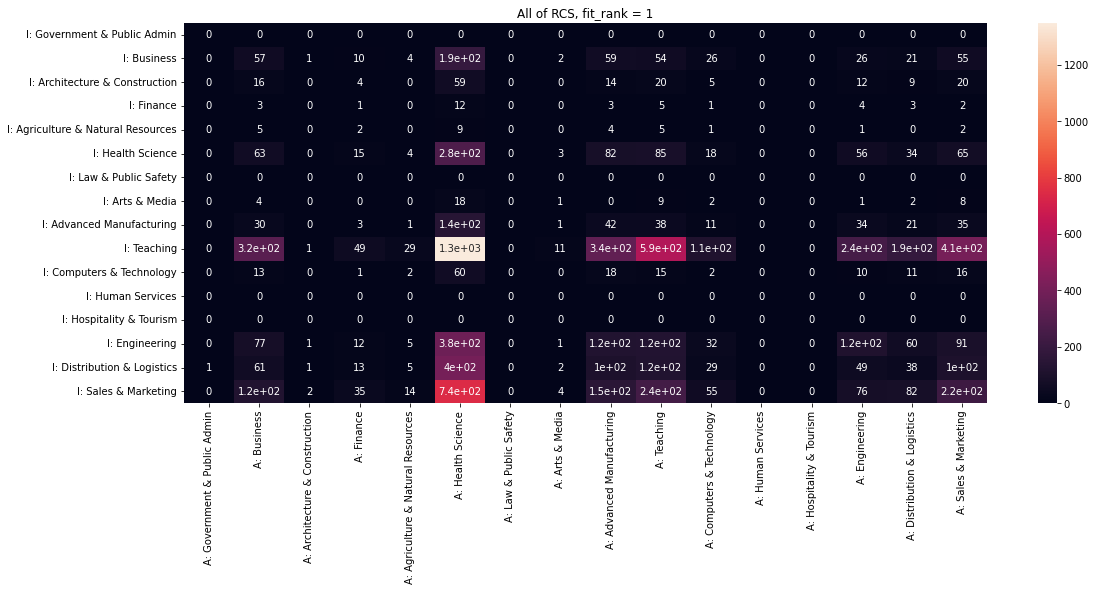

In [226]:
df = YouScienceDemand('../YouScienceData/')
len(df)

<AxesSubplot:>

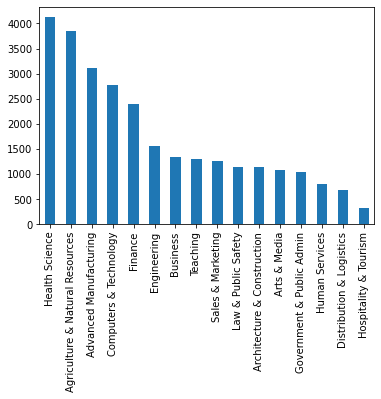

In [125]:
# determine the frequency of the aptitudes/interests and most commonly paired with
# can we create a labelling mechanism from the pairs? 
df.aptitude_fit.value_counts().plot.bar()

In [170]:
X = pd.DataFrame(df.aptitude_fit.value_counts())
aptitudes = list(X.index)

In [171]:
X

,aptitude_fit
Health Science,4120
Agriculture & Natural Resources,3840
Advanced Manufacturing,3118
Computers & Technology,2776
Finance,2395
Engineering,1558
Business,1334
Teaching,1307
Sales & Marketing,1254
Law & Public Safety,1137


In [156]:
# how to find frequency of interests per aptitude
apt = aptitudes[2]
temp_df = df.loc[df.aptitude_fit == apt]
temp_df.interest_fit.value_counts().index[0]

Arts & Media                       399
Teaching                           341
Health Science                     339
Engineering                        272
Business                           272
Human Services                     266
Sales & Marketing                  218
Agriculture & Natural Resources    180
Distribution & Logistics           176
Computers & Technology             146
Architecture & Construction        142
Advanced Manufacturing             133
Finance                            110
Law & Public Safety                 93
Hospitality & Tourism               22
Government & Public Admin            9
Name: interest_fit, dtype: int64

In [195]:
list(set(df.aptitude_fit)) 

['Government & Public Admin',
 'Business',
 'Arts & Media',
 'Architecture & Construction',
 'Advanced Manufacturing',
 'Finance',
 'Agriculture & Natural Resources',
 'Health Science',
 'Teaching',
 'Computers & Technology',
 'Human Services',
 'Hospitality & Tourism',
 'Engineering',
 'Distribution & Logistics',
 'Law & Public Safety',
 'Sales & Marketing']

/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_68596/1403752528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.aptitude_fit == apt][apt] = 1
/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_68596/1403752528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.aptitude_fit == apt][apt] = 1
/var/folders/pt/y3bb3b4j7yz3zzczhxc5l9p0vbrddc/T/ipykernel_68596/1403752528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

TypeError: set expected at most 1 argument, got 2

235